In [1]:
# y cambio?

##  Parte I: Análisis de la base de hogares y tipo de ocupación
 Ahora que ya están familiarizados con la Encuesta Permanente de Hogares
 (EPH) y la desocupación, vamos a complejizar un poco la construcción de las
 tasas del desempleo. Relacionaremos la información a nivel hogar

In [71]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm     
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score

In [3]:
#Bases Tizi

base_ind_04_sucia = pd.read_stata(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP3\Individual_t104.dta")
base_ind_24_sucia = pd.read_excel(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP3\usu_individual_T124.xlsx")

base_hog_04_sucia = pd.read_stata(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP4\Hogar_t104.dta")
base_hog_24_sucia = pd.read_excel(r"C:\Users\tizip\OneDrive\Documentos\Tizi UdeSA\8- Ciencia de datos\Compu nueva\CC408-T1-4\TP4\usu_hogar_T124.xlsx")

### PUNTO 1 - TEORICO
Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen pueden ser predictivas de la desocupación y seria útil incluir para perfeccionar el ejercicio del TP3? Mencionen estas variables y justifiquen su elección.

### PUNTO 2
Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2004 y 2024 en formato .dta y .xls, respectivamente. La base de hogares se llama Hogar_t104.dta y usu_hogar_T124.xls, respectivamente. Eliminen todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos Aires y unan ambos trimestres en una sola base. Esto es, a la base de la encuesta individual de cada año (que usaron en el TP3) unan la base de la encuesta de hogar. Asegúrese de estar usando las variables CODUSU y NRO_Hogar para el merge.


In [4]:
# LIMPIO BASE INDIVIDUAL

# me quedo solo con los valores de CABA y GBA
base_ind_04_filtrada = base_ind_04_sucia.loc[base_ind_04_sucia['aglomerado'].isin(['Ciudad de Buenos Aires', 'Partidos del GBA'])]
base_ind_24_filtrada = base_ind_24_sucia.loc[base_ind_24_sucia['AGLOMERADO'].isin([32, 33])]

#Para poder unir sin problema, me aseguro que als variables esten en el mismo formato

base_ind_04_filtrada.columns = base_ind_04_filtrada.columns.str.lower()
base_ind_24_filtrada.columns = base_ind_24_filtrada.columns.str.lower()

# concateno las bases
base_ind_prelimpieza = pd.concat([base_ind_24_filtrada, base_ind_04_filtrada])
print(base_ind_prelimpieza.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'componente', 'h15', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp

In [5]:
# LIMPIO BASE HOGAR

# me quedo solo con los valores de CABA y GBA
base_hog_04_filtrada = base_hog_04_sucia.loc[base_hog_04_sucia['aglomerado'].isin(['Ciudad de Buenos Aires', 'Partidos del GBA'])]
base_hog_24_filtrada = base_hog_24_sucia.loc[base_hog_24_sucia['AGLOMERADO'].isin([32, 33])]

#Para poder unir sin problema, me aseguro que als variables esten en el mismo formato
base_hog_04_filtrada.columns = base_hog_04_filtrada.columns.str.lower()
base_hog_24_filtrada.columns = base_hog_24_filtrada.columns.str.lower()

# concateno las bases
base_hog_prelimpieza = pd.concat([base_hog_24_filtrada, base_hog_04_filtrada])
print(base_hog_prelimpieza.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'realizada', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'pondih', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'idimph']


In [6]:
#Mergeo las dos bases

base_prelimpieza = pd.merge(base_ind_prelimpieza, base_hog_prelimpieza, on=["codusu", "nro_hogar"], how="inner")
print(base_prelimpieza.columns.tolist())

['codusu', 'ano4_x', 'trimestre_x', 'nro_hogar', 'componente', 'h15', 'region_x', 'mas_500_x', 'aglomerado_x', 'pondera_x', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', '

In [7]:
# me fijo que las que aparecen en ambas bases no tengan valores diferentes 
variables_comunes = ['adeccfr', 'adecifr', 'aglomerado', 'ano4', 'codusu', 'deccfr', 'decifr', 'gdeccfr', 'gdecifr', 'ideccfr', 'idecifr', 'ipcf', 'itf', 'mas_500', 'nro_hogar', 'pdeccfr', 'pdecifr', 'pondera', 'pondih', 'rdeccfr', 'rdecifr', 'region', 'trimestre']

# Crear un diccionario para almacenar los resultados
diferencias_resumen = {}

# Analizar cada variable
for var in variables_comunes:
    columna_x = f"{var}_x"
    columna_y = f"{var}_y"
    
    # Comparar las columnas (asegúrate de que existen en la base)
    if columna_x in base_prelimpieza.columns and columna_y in base_prelimpieza.columns:
        # Identificar diferencias
        diferencias = base_prelimpieza[columna_x] != base_prelimpieza[columna_y]
        diferencias_count = diferencias.sum()
        
        # Almacenar resultados en el diccionario
        diferencias_resumen[var] = diferencias_count

# Convertir el resumen a un DataFrame para una mejor visualización
import pandas as pd
resumen_df = pd.DataFrame.from_dict(diferencias_resumen, orient="index", columns=["Diferencias"])
resumen_df.index.name = "Variable"
resumen_df.reset_index(inplace=True)

# Mostrar las diferencias
print(resumen_df)

      Variable  Diferencias
0      adeccfr            0
1      adecifr            0
2   aglomerado            0
3         ano4            0
4       deccfr            0
5       decifr            0
6      gdeccfr            0
7      gdecifr            0
8      ideccfr         7051
9      idecifr         7051
10        ipcf          334
11         itf            0
12     mas_500            0
13     pdeccfr         7051
14     pdecifr         7051
15     pondera            0
16      pondih         7647
17     rdeccfr            0
18     rdecifr            0
19      region            0
20   trimestre            0


In [8]:
# Mergeo las dos bases bien, fijandome que no duplique las variables 
base_prelimpieza = pd.merge(base_ind_prelimpieza, base_hog_prelimpieza, on=["codusu", "nro_hogar"], suffixes=('', '_dup'))

# Eliminar columnas duplicadas con sufijo '_dup'
for col in base_prelimpieza.columns:
    if col.endswith('_dup') and base_prelimpieza[col[:-4]].equals(base_prelimpieza[col]):base_prelimpieza.drop(columns = col, inplace = True)

print(base_prelimpieza.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'componente', 'h15', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp

### PUNTO 3
Limpien la base de datos tomando criterios que hagan sentido. Explicar cualquier decisión como el tratamiento de valores faltantes (missing values), extremos (outliers), o variables categóricas. Justifique sus decisiones.

In [10]:
# TRATAMIENTO CATEGORICAS

# como hay datos que tienen distintas etiquetas en las dos bases que concatenamos, tenemos que  renombrar las etiquetas de una de las bases asi se pueden tener todos los datos con el mismo valor
variables_interes = base_prelimpieza[["ch03","ch04", "ch06", "ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado",  "v5", "v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b", "pp02h"]]

for i in variables_interes:
    if i == "ch03":
        base_prelimpieza['ch03'] = base_prelimpieza['ch03'].replace({
            'Jefe' : 1,
            'Cónyuge/Pareja' : 2,
            'Hijo/Hijastro' : 3,
            'Yerno/Nuera' : 4,
            'Nieto' : 5,
            'Madre/Padre' : 6,
            'Suegro' : 7,
            'Hermano' : 8,
            'Otros familiares' : 9,
            'No familiares' : 10})
    elif i == "ch04": 
        base_prelimpieza['ch04'] = base_prelimpieza['ch04'].replace({
            'Mujer': 2,
            'Varón': 1})
    elif i == "ch06":
        base_prelimpieza['ch06'] = base_prelimpieza['ch06'].replace({
            '98 y más años' : 98, 
            'Menos de 1 año' : 0})
        # cambio el formato de los valores de esta columna porque la mitad estaba en float y la mitas en int
        base_prelimpieza['ch06'] = base_prelimpieza['ch06'].astype(int)
    elif i == "ch07":
        base_prelimpieza['ch07'] = base_prelimpieza['ch07'].replace({
            'Unido': 1, 
            'Casado': 2, 
            'Separado o divorciado': 3, 
            'Viudo': 4, 
            'Soltero': 5})
    elif i == "ch08":
        base_prelimpieza['ch08'] = base_prelimpieza['ch08'].replace({
            'Obra social (incluye PAMI)': 1,  
            'Mutual/Prepaga/Servicio de emergencia': 2,  
            'Planes y seguros públicos': 3,  
            'No paga ni le descuentan': 4,  
            'Ns./Nr.': 9,  
            'Obra social y mutual/prepaga/servicio de emergencia': 12,  
            'Obra social y planes y seguros públicos': 13,  
            'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23,
            'Obra Social, mutual/prepaga/servicio de emergencia y planes y seguros públicos': 123})
    elif i == "nivel_ed":
        base_prelimpieza['nivel_ed'] = base_prelimpieza['nivel_ed'].replace({
            'Primaria Incompleta (incluye educación especial)': 1,  
            'Primaria Completa': 2,  
            'Secundaria Incompleta': 3,  
            'Secundaria Completa': 4,  
            'Superior Universitaria Incompleta': 5,  
            'Superior Universitaria Completa': 6, 
            'Sin instrucción': 7,  
            'Ns./Nr.': 9})
    elif i == "estado":
        base_prelimpieza['estado'] = base_prelimpieza['estado'].replace({
            'Ocupado': 1,  
            'Desocupado': 2,  
            'Inactivo': 3,  
            'Menor de 10 años': 4,  
            'Entrevista individual no realizada (no respuesta al cuestion': 0})
    elif i == "cat_inac":
        base_prelimpieza['cat_inac'] = base_prelimpieza['cat_inac'].replace({
            0.0 : 0,
            'Jubilado/pensionado': 1,  
            'Rentista': 2,  
            'Estudiante': 3,  
            'Ama de casa': 4,  
            'Menor de 6 años': 5,  
            'Discapacitado': 6,  
            'Otros': 7})
    elif i == "componente":
        base_prelimpieza['componente'] = base_prelimpieza['componente'].replace({
            'Servicio doméstico en hogares': 51})
        base_prelimpieza['componente'] = base_prelimpieza['componente'].astype(int)
    elif i == "h15":
        base_prelimpieza['h15'] = base_prelimpieza['h15'].replace({
            "Sí": 1,
            "No": 0,
            2 : 0})
        base_prelimpieza['h15'] = base_prelimpieza['h15'].astype(int)
    elif i == "mas_500":
        base_prelimpieza['mas_500'] = base_prelimpieza['mas_500'].replace({
            'N' : 1,
            'S' : 0})
    elif i == "aglomerado":
        base_prelimpieza['aglomerado'] = base_prelimpieza['aglomerado'].replace({
            'Ciudad de Buenos Aires' : 32,
            'Partidos del GBA' : 33})
    elif i == "v5":
        base_prelimpieza['v5'] = base_prelimpieza['v5'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v6":
        base_prelimpieza['v6'] = base_prelimpieza['v6'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})    
        base_prelimpieza['v6'] = base_prelimpieza['v6'].astype(int)
    elif i == "v7":
        base_prelimpieza['v7'] = base_prelimpieza['v7'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v8":
        base_prelimpieza['v8'] = base_prelimpieza['v8'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v11":
        base_prelimpieza['v11'] = base_prelimpieza['v11'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v12":
        base_prelimpieza['v12'] = base_prelimpieza['v12'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v13":
        base_prelimpieza['v13'] = base_prelimpieza['v13'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v17":
        base_prelimpieza['v17'] = base_prelimpieza['v17'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})    
    elif i == "v19_a":
        base_prelimpieza['v19_a'] = base_prelimpieza['v19_a'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "v19_b":
        base_prelimpieza['v19_b'] = base_prelimpieza['v19_b'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
    elif i == "pp02h":
        base_prelimpieza['pp02h'] = base_prelimpieza['pp02h'].replace({
            "Sí": 1,
            "No": 2,
            "Ns./Nr.":9})
        base_prelimpieza['pp02h'] = base_prelimpieza['pp02h'].astype(int)

    conteo = base_prelimpieza.groupby(i).size()
    print("\n", "La cantidad de datos en la variable", i, "por valor de etiqueta", "\n", conteo)


 La cantidad de datos en la variable ch03 por valor de etiqueta 
 ch03
1     4896
2     2801
3     5614
4      144
5      562
6      180
7       57
8      174
9      196
10      74
dtype: int64

 La cantidad de datos en la variable ch04 por valor de etiqueta 
 ch04
1    6973
2    7725
dtype: int64

 La cantidad de datos en la variable ch06 por valor de etiqueta 
 ch06
-1      51
 0     131
 1     180
 2     198
 3     191
      ... 
 94      4
 95      2
 96      4
 97      1
 98      4
Length: 100, dtype: int64

 La cantidad de datos en la variable ch07 por valor de etiqueta 
 ch07
1    2118
2    3879
3     797
4     829
5    7062
9      13
dtype: int64

 La cantidad de datos en la variable ch08 por valor de etiqueta 
 ch08
1     7876
2     1176
3       49
4     5321
9       36
12     232
13       3
23       5
dtype: int64

 La cantidad de datos en la variable nivel_ed por valor de etiqueta 
 nivel_ed
1    2273
2    2374
3    2790
4    2696
5    1583
6    1755
7    1227
dtype: int64


C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\664538799.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_prelimpieza['ch03'] = base_prelimpieza['ch03'].replace({
C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\664538799.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_prelimpieza['ch04'] = base_prelimpieza['ch04'].replace({
C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\664538799.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the ol


 La cantidad de datos en la variable cat_inac por valor de etiqueta 
 cat_inac
0    7193
1    1385
2      32
3    3034
4    1469
5    1165
6     100
7     320
dtype: int64

 La cantidad de datos en la variable componente por valor de etiqueta 
 componente
1     4828
2     3851
3     2602
4     1707
5      844
6      397
7      214
8      111
9       60
10      32
11      17
12      13
13       7
14       2
15       2
51      11
dtype: int64

 La cantidad de datos en la variable h15 por valor de etiqueta 
 h15
0     2094
1    12604
dtype: int64

 La cantidad de datos en la variable mas_500 por valor de etiqueta 
 mas_500
0    14698
dtype: int64

 La cantidad de datos en la variable aglomerado por valor de etiqueta 
 aglomerado
32     3258
33    11440
dtype: int64

 La cantidad de datos en la variable v5 por valor de etiqueta 
 v5
1     1792
2    12876
9       30
dtype: int64

 La cantidad de datos en la variable v6 por valor de etiqueta 
 v6
0        7
1     1382
2    13279
9       30


C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\664538799.py:114: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_prelimpieza['v11'] = base_prelimpieza['v11'].replace({
C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\664538799.py:119: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_prelimpieza['v12'] = base_prelimpieza['v12'].replace({
C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\664538799.py:124: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the ol

In [11]:
# VALORES NEGATIVOS EN EDAD

valores_negativos_edad = base_prelimpieza['ch06'] < 0
# Cantidad de datos negativos
cantidad_negativos_edad = valores_negativos_edad.sum()
print("Cantidad de valores negativos en variable edad:", cantidad_negativos_edad)

# Me quedo con los valores mayores o iguales a 0 de edad
base_prelimpieza = base_prelimpieza[base_prelimpieza['ch06'] >= 0]
valores_negativos_edad_post = base_prelimpieza['ch06'] < 0
cantidad_negativos_edad_post = valores_negativos_edad_post.sum()
print("Cantidad de valores negativos en variable edad post limpieza :", cantidad_negativos_edad_post)

Cantidad de valores negativos en variable edad: 51
Cantidad de valores negativos en variable edad post limpieza : 0


In [13]:
# VALORES NEGATIVOS EN INGRESO POR CIRCULO FAMILIAR

valores_negativos_ipcf = base_prelimpieza[base_prelimpieza['ipcf'] < 0]
# Cantidad de datos negativos
cantidad_negativos_ipcf = len(valores_negativos_ipcf)

# Mostrar resultados
print("Cantidad de valores negativos en variable ipcf:", cantidad_negativos_ipcf)

Cantidad de valores negativos en variable ipcf: 0


In [14]:
#  MISSING VALUES

# ver si los valores de ns/nr se pueden tomar como missing values
columnas = ['v5', 'v6', "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b"]

# reemplazo los valores "9" por NaN en las columnas seleccionadas
base_prelimpieza[columnas] = base_prelimpieza[columnas].replace(9, pd.NA)

# Contar cuántos NaN hay en las columnas seleccionadas
missing_count = base_prelimpieza[columnas].isna().sum()
print("la cantidad de NA es: ", missing_count)

# Eliminar filas con NaN en las columnas seleccionadas
base_limpia = base_prelimpieza.dropna(subset = columnas)

# Ver el DataFrame resultante
base_limpia.shape

la cantidad de NA es:  v5       30
v6       30
v7       30
v8       30
v11      30
v12      30
v13      33
v17      30
v19_a    30
v19_b    30
dtype: int64


(14614, 248)

In [15]:
conteo = (base_limpia['estado'] == 0).sum()
print(f"El número de filas donde 'estado' es igual a 0 es: {conteo}")


El número de filas donde 'estado' es igual a 0 es: 34


Datos originales: (14614, 248)
Datos sin outliers: (13581, 248)


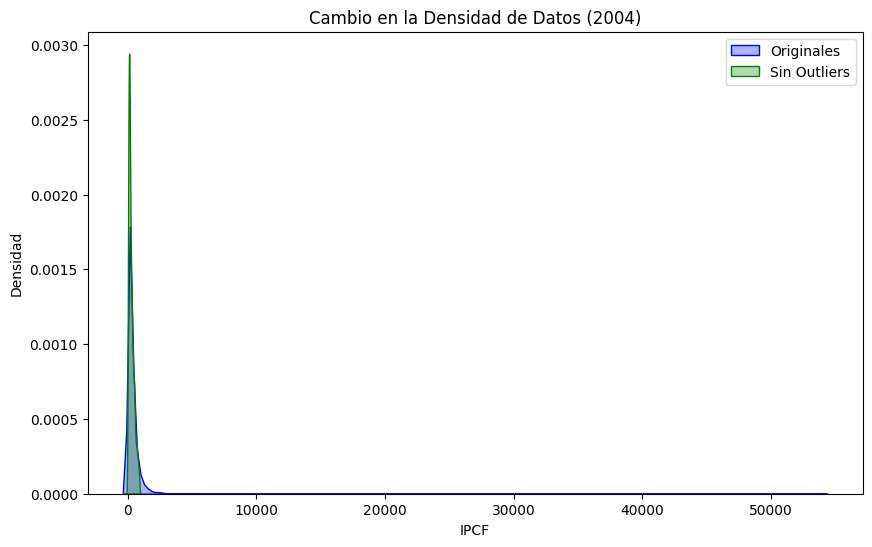

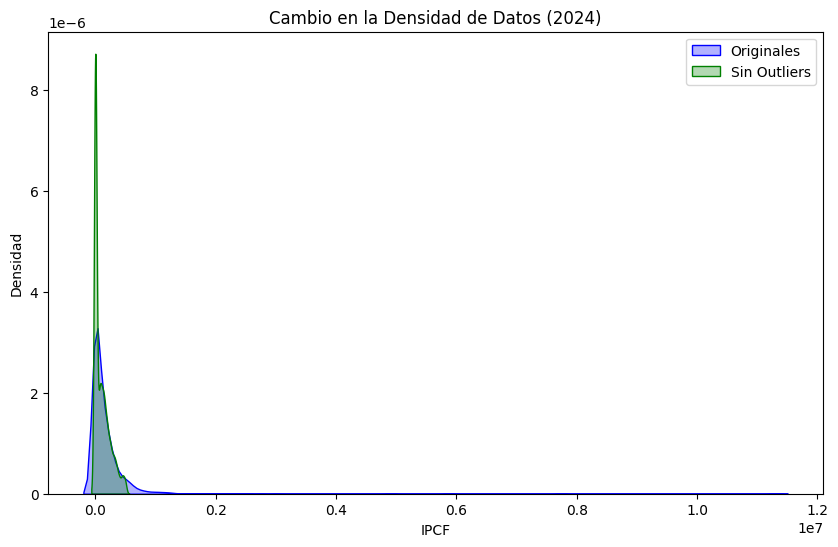

In [16]:
# OUTLIERS IPCF TOMANDO EN CUENTA AÑO DE RELEVAMIENTO

# Crear una función para calcular los límites de outliers y filtrar
def eliminar_outliers_por_grupo(df, col_variable, col_target):
    # Crear un DataFrame vacío para guardar los resultados filtrados
    df_sin_outliers = pd.DataFrame()
    # Iterar por cada grupo único de la variable
    for valor in df[col_variable].unique():
        # Filtrar por el valor actual de la variable
        grupo = df[df[col_variable] == valor]
        # Calcular los cuartiles y el IQR
        Q1 = grupo[col_target].quantile(0.25)  # Primer cuartil
        Q3 = grupo[col_target].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1
        # Calcular los límites
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        # Filtrar el grupo eliminando los outliers
        grupo_filtrado = grupo[(grupo[col_target] >= lower_limit) & (grupo[col_target] <= upper_limit)]
        # Añadir el grupo filtrado al DataFrame final
        df_sin_outliers = pd.concat([df_sin_outliers, grupo_filtrado], ignore_index=True)
    return df_sin_outliers

# Aplicar la función al DataFrame original
base_limpia_sin_outliers = eliminar_outliers_por_grupo(base_limpia, 'ano4', 'ipcf')
# Verificar el tamaño del DataFrame resultante
print(f"Datos originales: {base_limpia.shape}")
print(f"Datos sin outliers: {base_limpia_sin_outliers.shape}")



# Filtrar los datos para el año 2004
datos_2004_originales = base_limpia[base_limpia['ano4'] == 2004]
datos_2004_sin_outliers = base_limpia_sin_outliers[base_limpia_sin_outliers['ano4'] == 2004]
# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))
sns.kdeplot(datos_2004_originales['ipcf'], label='Originales', color='blue', fill=True, alpha=0.3)
sns.kdeplot(datos_2004_sin_outliers['ipcf'], label='Sin Outliers', color='green', fill=True, alpha=0.3)
plt.title('Cambio en la Densidad de Datos (2004)')
plt.xlabel('IPCF')
plt.ylabel('Densidad')
plt.legend()
plt.show()



# Filtrar los datos para el año 2004
datos_2024_originales = base_limpia[base_limpia['ano4'] == 2024]
datos_2024_sin_outliers = base_limpia_sin_outliers[base_limpia_sin_outliers['ano4'] == 2024]
# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))
sns.kdeplot(datos_2024_originales['ipcf'], label='Originales', color='blue', fill=True, alpha=0.3)
sns.kdeplot(datos_2024_sin_outliers['ipcf'], label='Sin Outliers', color='green', fill=True, alpha=0.3)
plt.title('Cambio en la Densidad de Datos (2024)')
plt.xlabel('IPCF')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [17]:
# nueva base final
# agarre los valores 
base_final = base_limpia_sin_outliers[[ "ano4", "codusu", "ix_tot", "ipcf", "ch03", "ch04", "ch06","ch07", "ch08", "nivel_ed", "estado", "cat_inac", "componente", "h15", "mas_500", "aglomerado", "v5", "v6", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b", "pp02h"]]
print(base_final)

         ano4                         codusu  ix_tot           ipcf  ch03  \
0      2024.0  TQRMNOSUWHLKMUCDEIJAH00855260     3.0       0.000000     1   
1      2024.0  TQRMNOSUWHLKMUCDEIJAH00855260     3.0       0.000000     3   
2      2024.0  TQRMNOSUWHLKMUCDEIJAH00855260     3.0       0.000000     4   
3      2024.0  TQSMNORWVHLLKQCDEIJAH00856914     1.0  500000.000000     1   
4      2024.0  TQRMNOPQQHLOLRCDEIJAH00855133     1.0       0.000000     1   
...       ...                            ...     ...            ...   ...   
13576  2004.0                       288171       3.0     533.333333     3   
13577  2004.0                       288405       4.0     100.000000     1   
13578  2004.0                       288405       4.0     100.000000     2   
13579  2004.0                       288405       4.0     100.000000     3   
13580  2004.0                       288405       4.0     100.000000     3   

       ch04  ch06  ch07  ch08  nivel_ed  ...  v6  v7  v8  v11  v12  v13 v17

In [18]:
conteo = (base_final['estado'] == 0).sum()
print(f"El número de filas donde 'estado' es igual a 0 es: {conteo}")

El número de filas donde 'estado' es igual a 0 es: 34


In [19]:
# CATEGORICAS A DUMMIES
#Paramos de categoricas a dummies las variables con mas de una categoria
base_final_dummies = pd.get_dummies(base_final, columns = [ "ch03", "ch04","ch07", "ch08", "nivel_ed", "estado", "mas_500", "aglomerado"], drop_first=False)

#Pasamos a dummies las binarias
def transformar_a_dummies(dataframe, columnas):
    print("Antes de  transformación:")
    print(dataframe[columnas].head())  # Mostrar solo las columnas seleccionadas
    for columna in columnas:
        dataframe[columna] = dataframe[columna].apply(lambda x: 1 if x == 1 else (0 if x == 2 else x))
    print("\nPost transformación:")
    print(dataframe[columnas].head())  # Mostrar nuevamente solo las columnas seleccionadas para verificar el cambio

# Lista de columnas a transformar
columnas_a_transformar = ["h15","v5", "v7", "v8", "v11", "v12", "v13", "v17", "v19_a", "v19_b"]
# Aplicar la función directamente a base_limpia
transformar_a_dummies(base_final_dummies, columnas_a_transformar)
print(base_final_dummies.columns.tolist())

print(base_final_dummies.shape)

Antes de  transformación:
   h15 v5 v7 v8 v11 v12 v13 v17 v19_a v19_b
0    1  2  2  2   2   2   2   2     2     2
1    1  2  2  2   2   2   2   2     2     2
2    1  2  2  2   2   2   2   2     2     2
3    1  2  2  2   2   2   2   2     2     2
4    1  2  2  2   2   2   2   2     2     2

Post transformación:
   h15  v5  v7  v8  v11  v12  v13  v17  v19_a  v19_b
0    1   0   0   0    0    0    0    0      0      0
1    1   0   0   0    0    0    0    0      0      0
2    1   0   0   0    0    0    0    0      0      0
3    1   0   0   0    0    0    0    0      0      0
4    1   0   0   0    0    0    0    0      0      0
['ano4', 'codusu', 'ix_tot', 'ipcf', 'ch06', 'cat_inac', 'componente', 'h15', 'v5', 'v6', 'v7', 'v8', 'v11', 'v12', 'v13', 'v17', 'v19_a', 'v19_b', 'pp02h', 'ch03_1', 'ch03_2', 'ch03_3', 'ch03_4', 'ch03_5', 'ch03_6', 'ch03_7', 'ch03_8', 'ch03_9', 'ch03_10', 'ch04_1', 'ch04_2', 'ch07_1', 'ch07_2', 'ch07_3', 'ch07_4', 'ch07_5', 'ch07_9', 'ch08_1', 'ch08_2', 'ch08_3', 'c

### PUNTO 4
Construya variables (mínimo 3) que no estén en la base pero que sean relevantes para predecir individuos desocupados (por ejemplo, la proporción de personas que trabajan en el hogar).

In [20]:
 # Calcular la proporción de trabajadores por hogar agrupando por CODUSU y año
proporcion_trabajadores = base_final_dummies.groupby(['codusu', 'ano4'])['estado_1'].sum() / base_final_dummies.groupby(['codusu', 'ano4'])['ix_tot'].sum()

# Convertir el resultado a un DataFrame y restablecer el índice
proporcion_trabajadores_df = proporcion_trabajadores.reset_index()
proporcion_trabajadores_df = proporcion_trabajadores_df.rename(columns={0: 'proporcion_trabajadores'})

# Agregar la proporción como una nueva columna 
base_final_dummies = base_final_dummies.merge(proporcion_trabajadores_df, on=['codusu', 'ano4'],  how='left')

# Verificar que la columna se ha agregado correctamente
base_final_dummies['proporcion_trabajadores']

0        0.333333
1        0.333333
2        0.333333
3        1.000000
4        0.000000
           ...   
13576    0.111111
13577    0.187500
13578    0.187500
13579    0.187500
13580    0.187500
Name: proporcion_trabajadores, Length: 13581, dtype: float64

In [21]:
# Calcular el total de ayudas externas por hogar y por año
base_final_dummies['total_ayudas'] = base_final_dummies[['v5', 'v6', 'v7', 'v12']].sum(axis=1)

# Calcular la proporción de ayudas externas por hogar y por año
proporcion_ayudas = base_final_dummies.groupby(['codusu', 'ano4'])['total_ayudas'].sum() / base_final_dummies.groupby(['codusu', 'ano4'])['ix_tot'].sum()

# Convertir el resultado a un DataFrame y restablecer el índice
proporcion_ayudas_df = proporcion_ayudas.reset_index()
proporcion_ayudas_df = proporcion_ayudas_df.rename(columns={0: 'ingreso_externo'})

# Agregar la proporción como una nueva columna en el DataFrame original
base_final_dummies = base_final_dummies.merge(proporcion_ayudas_df, on=['codusu', 'ano4'],  # Asegúrate de usar las columnas correctas para hacer la fusión
                                              how='left')

# Verificar que la columna se ha agregado correctamente
print(base_final_dummies[['codusu', 'ano4', 'ingreso_externo']].head())

                          codusu    ano4 ingreso_externo
0  TQRMNOSUWHLKMUCDEIJAH00855260  2024.0        0.666667
1  TQRMNOSUWHLKMUCDEIJAH00855260  2024.0        0.666667
2  TQRMNOSUWHLKMUCDEIJAH00855260  2024.0        0.666667
3  TQSMNORWVHLLKQCDEIJAH00856914  2024.0             2.0
4  TQRMNOPQQHLOLRCDEIJAH00855133  2024.0             2.0


In [22]:
# Calcular el total de trabajo infantil en el hogar
base_final_dummies["total_infante"] = base_final_dummies[["v19_a", "v19_b"]].sum(axis=1)

# Reemplazar ceros en 'ix_tot' con NaN para evitar divisiones por cero
base_final_dummies['ix_tot'].replace(0, np.nan, inplace=True)

# Agrupar por hogar para calcular la proporción de ingresos provenientes del trabajo infantil
base_final_dummies["ingreso_infante"] = base_final_dummies.groupby('codusu')['total_infante'].transform('sum') / base_final_dummies.groupby('codusu')['ix_tot'].transform('sum')

# Mostrar la columna 'ingreso_infante' y verificar los resultados
print(base_final_dummies[['ingreso_infante']].drop_duplicates().head())

       ingreso_infante
0             0.000000
244           0.250000
9941          0.333333
12225         0.200000


C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\1065245088.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_final_dummies['ix_tot'].replace(0, np.nan, inplace=True)


In [23]:
print(base_final_dummies["v13"])

0        0
1        0
2        0
3        0
4        0
        ..
13576    1
13577    0
13578    0
13579    0
13580    0
Name: v13, Length: 13581, dtype: int64


In [24]:
# VENTA DE PERTENENCIAS Y FGASTO DE AHORROS POR HOGAR
# Crear la columna "venta_pertenencias"
base_final_dummies["venta_pertenencias"] = ((base_final_dummies["v13"] == 1) & (base_final_dummies["v17"] == 1)).astype(int)

# Calcular la proporción de ingresos por ventas
base_final_dummies["ingreso_ventas"] = base_final_dummies["venta_pertenencias"] / base_final_dummies["ix_tot"]

# Mostrar la columna "ingreso_ventas"
print(base_final_dummies[["ingreso_ventas"]])
print(base_final_dummies["ingreso_ventas"].sum())


       ingreso_ventas
0                 0.0
1                 0.0
2                 0.0
3                 0.0
4                 0.0
...               ...
13576             0.0
13577             0.0
13578             0.0
13579             0.0
13580             0.0

[13581 rows x 1 columns]
196.52380952380952


### PUNTO 5
Presenten estadísticas descriptivas de tres variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir la desocupación. Comenten las estadísticas obtenidas.

In [25]:
base_final.shape

(13581, 27)

In [26]:
base_final_dummies.shape

(13581, 67)

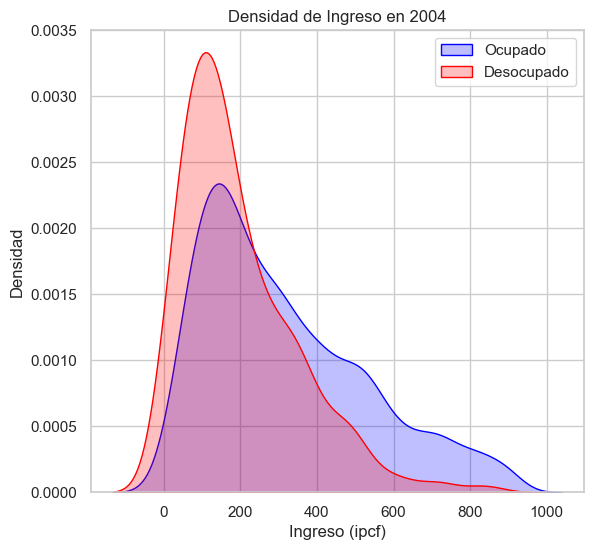

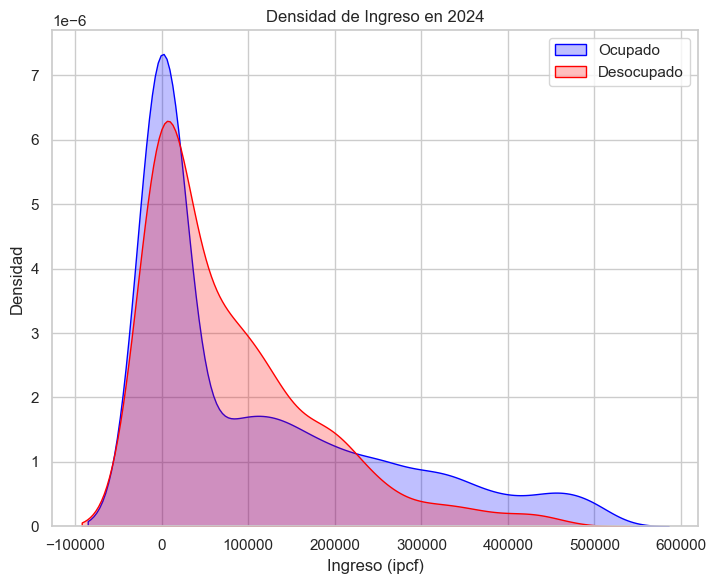

In [27]:
# Filtrar los datos para el año 2024 y 2004
base_2024 = base_final[base_final['ano4'] == 2024]
base_2004 = base_final[base_final['ano4'] == 2004]

# Configuración de los gráficos
sns.set(style="whitegrid")

# Crear gráficos de densidad para 2004
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # Subgráfico para el año 2004
sns.kdeplot(data=base_2004[base_2004['estado'] == 1], x='ipcf', label='Ocupado', color='blue', fill=True)
sns.kdeplot(data=base_2004[base_2004['estado'] == 2], x='ipcf', label='Desocupado', color='red', fill=True)
plt.title('Densidad de Ingreso en 2004')
plt.xlabel('Ingreso (ipcf)')
plt.ylabel('Densidad')
plt.legend()

# Crear gráficos de densidad para 2024
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)  # Subgráfico para el año 2024
sns.kdeplot(data=base_2024[base_2024['estado'] == 1], x='ipcf', label='Ocupado', color='blue', fill=True)
sns.kdeplot(data=base_2024[base_2024['estado'] == 2], x='ipcf', label='Desocupado', color='red', fill=True)
plt.title('Densidad de Ingreso en 2024')
plt.xlabel('Ingreso (ipcf)')
plt.ylabel('Densidad')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [28]:
# Calcular el promedio del ingreso por año
media_ipcf = base_final.groupby("ano4")['ipcf'].mean()
print("La media de ipcf por año es:")
print(media_ipcf)

# Calcular el desvío estándar del ingreso por año
std_ipcf = base_final.groupby("ano4")['ipcf'].std()
print("\nEl desvío estándar de ipcf por año es:")
print(std_ipcf)

La media de ipcf por año es:
ano4
2004.0      265.966008
2024.0    99542.244848
Name: ipcf, dtype: float64

El desvío estándar de ipcf por año es:
ano4
2004.0       201.436285
2024.0    126879.843966
Name: ipcf, dtype: float64


In [29]:
# Filtrar los datos para estado == 1 (desocupados)
base_final['ocupado'] = (base_final['estado'] == 1).astype(int)
# Calcular el porcentaje de ocupado por año
porcentaje_ocupado = base_final.groupby("ano4")['ocupado'].mean() * 100
print("Porcentaje de ocupado por año:")
print(porcentaje_ocupado)
# Calcular el desvío estándar del porcentaje de ocupado por año
std_ocupado = base_final.groupby("ano4")['ocupado'].std() * 100
print("\nDesvío estándar del porcentaje de desocupados por año:")
print(std_ocupado)

# Filtrar los datos para estado == 1 (desocupados)
base_final['desocupado'] = (base_final['estado'] == 2).astype(int)
# Calcular el porcentaje de desocupados por año
porcentaje_desocupado = base_final.groupby("ano4")['desocupado'].mean() * 100
print("Porcentaje de desocupados por año:")
print(porcentaje_desocupado)
# Calcular el desvío estándar del porcentaje de desocupados por año
std_desocupado = base_final.groupby("ano4")['desocupado'].std() * 100
print("\nDesvío estándar del porcentaje de desocupados por año:")
print(std_desocupado)

Porcentaje de ocupado por año:
ano4
2004.0    38.448519
2024.0    44.030196
Name: ocupado, dtype: float64

Desvío estándar del porcentaje de desocupados por año:
ano4
2004.0    48.650767
2024.0    49.646159
Name: ocupado, dtype: float64
Porcentaje de desocupados por año:
ano4
2004.0    7.235543
2024.0    4.745032
Name: desocupado, dtype: float64

Desvío estándar del porcentaje de desocupados por año:
ano4
2004.0    25.909379
2024.0    21.261643
Name: desocupado, dtype: float64


C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\2386283313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_final['ocupado'] = (base_final['estado'] == 1).astype(int)
C:\Users\tizip\AppData\Local\Temp\ipykernel_19656\2386283313.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_final['desocupado'] = (base_final['estado'] == 2).astype(int)


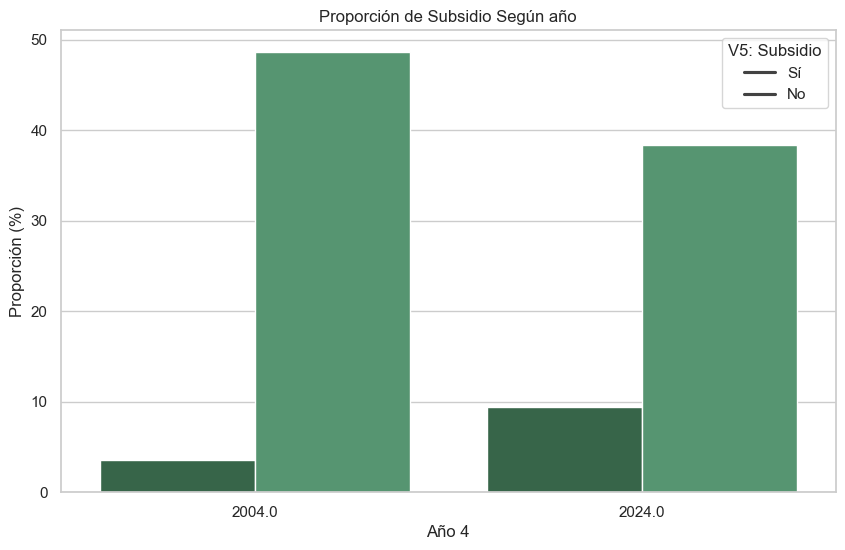

In [30]:
# Calcular las proporciones por año y tipo de subsidio (v5)
prop_subsidio_año = base_final.groupby(["ano4", "v5"])['v5'].count() / len(base_final) * 100
prop_subsidio_año = prop_subsidio_año.reset_index(name='proporcion')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=prop_subsidio_año, x='ano4', y='proporcion', hue='v5', palette=["#2F6D47", "#4C9F70"])
plt.title('Proporción de Subsidio Según año')
plt.xlabel('Año 4')
plt.ylabel('Proporción (%)')
plt.legend(title='V5: Subsidio', loc='upper right', labels=['Sí', 'No'])
plt.show()

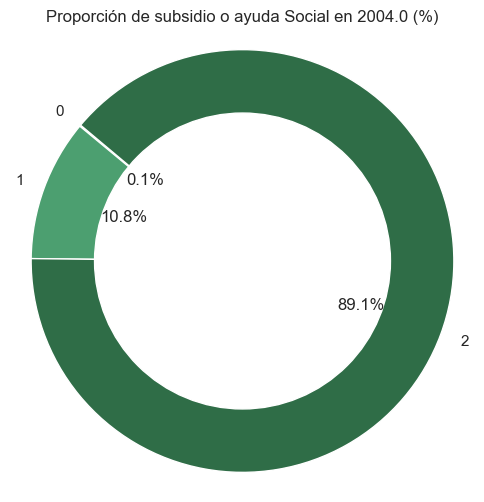

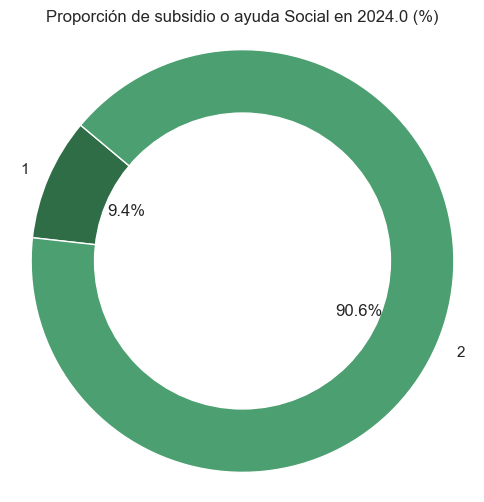

In [31]:
# Calcular la proporción de ayuda social para cada año (ano4)
prop_ayuda_año = base_final_dummies.groupby(["ano4", "v6"]).size() / base_final_dummies.groupby("ano4")["v6"].count() * 100
prop_ayuda_año = prop_ayuda_año.reset_index(name='proporcion')

# Colores personalizados
colores = ["#2F6D47", "#4C9F70"]

# Crear un gráfico de torta para cada año (ano4)
for ano in prop_ayuda_año['ano4'].unique():
    # Filtrar los datos para el año actual
    datos_ano = prop_ayuda_año[prop_ayuda_año['ano4'] == ano]

    # Crear el gráfico de torta
    plt.figure(figsize=(6, 6))
    plt.pie(datos_ano['proporcion'], labels=datos_ano['v6'], colors=colores, autopct='%1.1f%%', startangle=140)
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(f'Proporción de subsidio o ayuda Social en {ano} (%)')
    plt.axis('equal')  # Asegurar que sea un círculo
    plt.show()

## Parte II: Clasificación y regularización
El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona está desocupada o no. Esta vez utilizando distintas variables de características individuales y del hogar del encuestado. A su vez, incluiremos ejercicios de regularización y de validación cruzada.

In [33]:
# Imprimir las variables en el DataFrame base_final_dummies
print("Variables en base_final_dummies:")
print(base_final_dummies.columns)

Variables en base_final_dummies:
Index(['ano4', 'codusu', 'ix_tot', 'ipcf', 'ch06', 'cat_inac', 'componente',
       'h15', 'v5', 'v6', 'v7', 'v8', 'v11', 'v12', 'v13', 'v17', 'v19_a',
       'v19_b', 'pp02h', 'ch03_1', 'ch03_2', 'ch03_3', 'ch03_4', 'ch03_5',
       'ch03_6', 'ch03_7', 'ch03_8', 'ch03_9', 'ch03_10', 'ch04_1', 'ch04_2',
       'ch07_1', 'ch07_2', 'ch07_3', 'ch07_4', 'ch07_5', 'ch07_9', 'ch08_1',
       'ch08_2', 'ch08_3', 'ch08_4', 'ch08_9', 'ch08_12', 'ch08_13', 'ch08_23',
       'nivel_ed_1', 'nivel_ed_2', 'nivel_ed_3', 'nivel_ed_4', 'nivel_ed_5',
       'nivel_ed_6', 'nivel_ed_7', 'estado_0', 'estado_1', 'estado_2',
       'estado_3', 'estado_4', 'mas_500_0', 'aglomerado_32', 'aglomerado_33',
       'proporcion_trabajadores', 'total_ayudas', 'ingreso_externo',
       'total_infante', 'ingreso_infante', 'venta_pertenencias',
       'ingreso_ventas'],
      dtype='object')


In [34]:
base_final_dummies = base_final_dummies.drop(columns=['pp02h'])

In [35]:
# Base con datos que sí respondieron a la condición de actividad
respondieron = base_final_dummies[base_final_dummies['estado_0'] == 0]
respondieron_cant = respondieron.shape[0]

print("La cantidad de personas que respondieron a la pregunta de condición de actividad son:", respondieron_cant)

# Base con datos que no respondieron a la condición de actividad
no_respondieron = base_final_dummies[base_final_dummies['estado_0'] == 1]
no_respondieron_cant = no_respondieron.shape[0]

print("La cantidad de personas que no respondieron a la pregunta de condición de actividad son:", no_respondieron_cant)

La cantidad de personas que respondieron a la pregunta de condición de actividad son: 13547
La cantidad de personas que no respondieron a la pregunta de condición de actividad son: 34


### PUNTO 1
Para cada año, partan la base respondieron en una base de prueba y una de entrenamiento (X_train, y_train, X_test, y_test) utilizando el comando train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state instance) debe ser 101. Establezca a desocupado como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1).


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split

def preparar_datos(base, ano):
    """
    Prepara los conjuntos de entrenamiento y prueba para un año específico.
    Args:
        base: DataFrame original.
        ano: Año para filtrar los datos.
    Returns:
        X_train, y_train, X_test, y_test: Conjuntos de datos preparados.
    """
    # Filtrar los datos por año
    datos_ano = base[base['ano4'] == ano]  
    # Dividir los datos en conjuntos de entrenamiento y prueba
    train, test = train_test_split(datos_ano, test_size=0.3, random_state=101)
    # Separar características y variable objetivo para entrenamiento
    X_train = train.drop(columns=['estado_1', 'ano4','estado_0','estado_2', 'estado_3','estado_4','codusu'])
    y_train = (train['estado_2'] == 1).astype(int)
    # Agregar columna de intercepto
    X_train = X_train.assign(intercept=1)
    # Separar características y variable objetivo para prueba
    X_test = test.drop(columns=['estado_1', 'ano4','estado_0','estado_2', 'estado_3','estado_4','codusu'])
    y_test = (test['estado_2'] == 1).astype(int)
    # Agregar columna de intercepto
    X_test = X_test.assign(intercept=1)
    return X_train, y_train, X_test, y_test

# Preparar datos para 2004 y 2024
X_train_2004, y_train_2004, X_test_2004, y_test_2004 = preparar_datos(respondieron, 2004)
X_train_2024, y_train_2024, X_test_2024, y_test_2024 = preparar_datos(respondieron, 2024)

In [37]:
X_train_2004.describe().T

,count,mean,std,min,25%,50%,75%,max
ix_tot,4958.0,4.410044,2.134351,1.0,3.000000,4.00,5.000,15.000000
ipcf,4958.0,266.916567,202.453184,0.0,114.464286,200.00,375.000,905.000000
ch06,4958.0,32.781162,22.748618,0.0,14.000000,29.00,49.000,98.000000
cat_inac,4958.0,1.882211,2.024522,0.0,0.000000,1.00,3.000,7.000000
componente,4958.0,2.829770,2.554957,1.0,1.000000,2.00,4.000,51.000000
h15,4958.0,0.826946,0.378332,0.0,1.000000,1.00,1.000,1.000000
v5,4958.0,0.070190,0.255492,0.0,0.000000,0.00,0.000,1.000000
v7,4958.0,0.092981,0.290435,0.0,0.000000,0.00,0.000,1.000000
v8,4958.0,0.018959,0.136395,0.0,0.000000,0.00,0.000,1.000000
v11,4958.0,0.008471,0.091657,0.0,0.000000,0.00,0.000,1.000000


In [38]:
X_train_2024.describe().T

,count,mean,std,min,25%,50%,75%,max
ix_tot,4524.0,3.791556,1.910468,1.0,2.00,4.000000,5.000000,12.00
ipcf,4524.0,100001.417803,126095.186835,0.0,0.00,52000.000000,169000.000000,500000.00
ch06,4524.0,37.964633,22.954079,1.0,18.00,36.000000,56.000000,96.00
cat_inac,4524.0,1.671751,1.979306,0.0,0.00,1.000000,3.000000,7.00
componente,4524.0,2.414898,1.556670,1.0,1.00,2.000000,3.000000,13.00
h15,4524.0,0.888815,0.314396,0.0,1.00,1.000000,1.000000,1.00
v5,4524.0,0.198939,0.399246,0.0,0.00,0.000000,0.000000,1.00
v7,4524.0,0.064545,0.245748,0.0,0.00,0.000000,0.000000,1.00
v8,4524.0,0.024757,0.155400,0.0,0.00,0.000000,0.000000,1.00
v11,4524.0,0.047966,0.213719,0.0,0.00,0.000000,0.000000,1.00


In [40]:
# Iniciamos el Standard Scaler
sc = StandardScaler()

# Estandarizamos las observaciones de entrenamiento
X_train_2004_trans = pd.DataFrame(sc.fit_transform(X_train_2004), index=X_train_2004.index, columns=X_train_2004.columns)

# Estandarizamos las observaciones de test
X_test_2004_trans = pd.DataFrame(sc.transform(X_test_2004), index=X_test_2004.index, columns=X_test_2004.columns)

# Estadisticas luego de estandarizar
X_train_2004_trans.describe().T

,count,mean,std,min,25%,50%,75%,max
ix_tot,4958.0,1.791405e-16,1.000101,-1.597858,-0.660710,-0.192136,0.276438,4.962176
ipcf,4958.0,-1.719748e-17,1.000101,-1.318544,-0.753101,-0.330562,0.533923,3.152076
ch06,4958.0,5.732495e-18,1.000101,-1.441163,-0.825679,-0.166232,0.713031,2.867225
cat_inac,4958.0,2.579623e-17,1.000101,-0.929800,-0.929800,-0.435806,0.552181,2.528155
componente,4958.0,7.237275e-17,1.000101,-0.716237,-0.716237,-0.324801,0.458070,18.855539
h15,4958.0,2.579623e-17,1.000101,-2.185991,0.457459,0.457459,0.457459,0.457459
v5,4958.0,-1.719748e-17,1.000101,-0.274751,-0.274751,-0.274751,-0.274751,3.639660
v6,4958.0,-2.235673e-16,1.000101,-5.954648,0.349675,0.349675,0.349675,0.349675
v7,4958.0,-1.146499e-17,1.000101,-0.320176,-0.320176,-0.320176,-0.320176,3.123280
v8,4958.0,4.156059e-17,1.000101,-0.139017,-0.139017,-0.139017,-0.139017,7.193378


In [41]:
# Iniciamos el Standard Scaler
sc = StandardScaler()

# Estandarizamos las observaciones de entrenamiento
X_train_2024_trans = pd.DataFrame(sc.fit_transform(X_train_2024), index=X_train_2024.index, columns=X_train_2024.columns)

# Estandarizamos las observaciones de test
X_test_2024_trans = pd.DataFrame(sc.transform(X_test_2024), index=X_test_2024.index, columns=X_test_2024.columns)

# Estadisticas luego de estandarizar
X_train_2024_trans.describe().T

,count,mean,std,min,25%,50%,75%,max
ix_tot,4524.0,1.295751e-17,1.000111,-1.461351,-0.937862,0.109118,0.632608,4.297038
ipcf,4524.0,-6.282429e-18,1.000111,-0.793151,-0.793151,-0.380718,0.547255,3.172546
ch06,4524.0,1.492077e-16,1.000111,-1.610551,-0.869860,-0.085599,0.785802,2.528604
cat_inac,4524.0,-2.277381e-17,1.000111,-0.844708,-0.844708,-0.339424,0.671142,2.692275
componente,4524.0,-8.638340e-18,1.000111,-0.909027,-0.909027,-0.266559,0.375909,6.800587
h15,4524.0,8.010097e-17,1.000111,-2.827373,0.353685,0.353685,0.353685,0.353685
v5,4524.0,7.067733e-18,1.000111,-0.498342,-0.498342,-0.498342,-0.498342,2.006656
v6,4524.0,2.560090e-16,1.000111,-3.062049,0.326579,0.326579,0.326579,0.326579
v7,4524.0,4.162109e-17,1.000111,-0.262675,-0.262675,-0.262675,-0.262675,3.806987
v8,4524.0,-6.282429e-18,1.000111,-0.159328,-0.159328,-0.159328,-0.159328,6.276373


### PUNTO 2 - TEORICO
Expliquen brevemente cómo elegirían λ por validación cruzada (en Python es alpha). Detallen por qué no usarían el conjunto de prueba(test) para su elección.

### PUNTO 3 - TEORICO
En validación cruzada, ¿cuáles son las implicancias de usar un k muy pequeño o uno muy grande? Cuando k = n (con n el número de muestras), ¿cuántas veces se estima el modelo?

### PUNTO 4
Para regresión logística, implementen la penalidad, L1 como la de LASSO y L2 como la de Ridge con (como en la Tutorial 10), usando λ = 1 la opción penalty y reporten la matriz de confusión, la curva ROC, los valores de AUC y de Accuracy para cada año (En la clase magistral 9, vimos el método de regularización en regresión lineal donde la variable dependiente es numérica. En este caso, nuestra variable dependiente es binaria (ocupado, desocupado), por lo que usamos la regresión logística y aprovechamos la opción de penalidad para aplicar los métodos de regularización vistos en clase.) ¿Cómo cambiaron los resultados con respecto al TP3? ¿La performance de regresión logística con regularización es mejor o peor?


### 2004

2004. Matriz de confusión L1:
[[1951   16]
 [ 105   53]]
2004. Accuracy L1: 0.9430588235294117
2004. AUC L1: 0.934440418809084


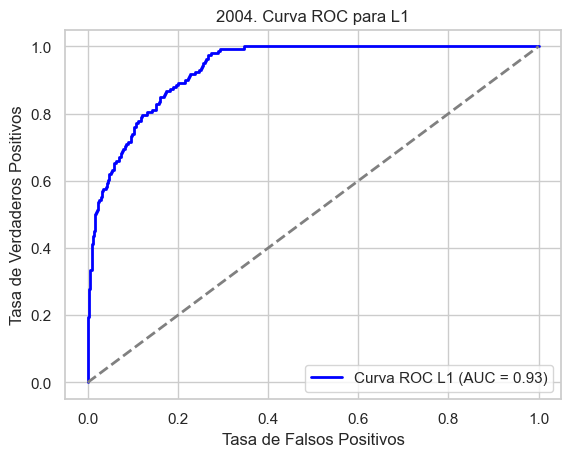


2004. Matriz de confusión L2:
[[1954   13]
 [ 108   50]]
2004. Accuracy L2: 0.9430588235294117
2004. AUC L2: 0.9247681684503163


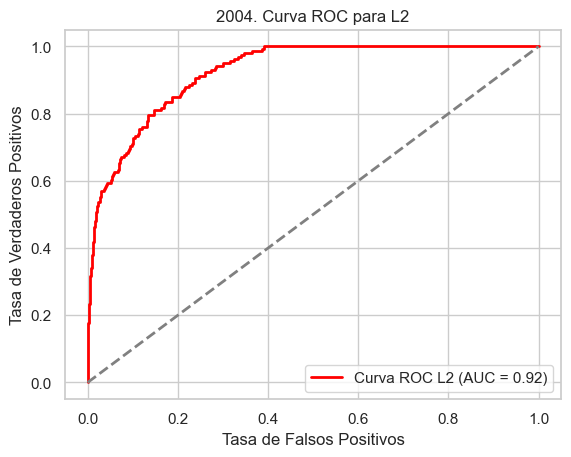

In [43]:
# Configuración del modelo de regresión logística con penalización L1 (LASSO)
model_l1_04 = LogisticRegression(penalty='l1', C=1, solver='liblinear')  # L1 penalidad, solver liblinear para L1
model_l1_04.fit(X_train_2004_trans, y_train_2004)
pred_l1_04 = model_l1_04.predict(X_test_2004_trans)
pred_prob_l1_04 = model_l1_04.predict_proba(X_test_2004_trans)[:, 1]

# Evaluación para L1
cm_l1_04 = confusion_matrix(y_test_2004, pred_l1_04)
accuracy_l1_04 = accuracy_score(y_test_2004, pred_l1_04)
fpr_l1_04, tpr_l1_04, _ = roc_curve(y_test_2004, pred_prob_l1_04)
roc_auc_l1_04 = auc(fpr_l1_04, tpr_l1_04)

print("2004. Matriz de confusión L1:")
print(cm_l1_04)
print("2004. Accuracy L1:", accuracy_l1_04)
print("2004. AUC L1:", roc_auc_l1_04)

# Visualización de la curva ROC para L1
plt.figure()
plt.plot(fpr_l1_04, tpr_l1_04, color='blue', lw=2, label='Curva ROC L1 (AUC = %0.2f)' % roc_auc_l1_04)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('2004. Curva ROC para L1')
plt.legend(loc='lower right')
plt.show()

# Configuración del modelo de regresión logística con penalización L2 (Ridge)
model_l2_04 = LogisticRegression(penalty='l2', C=1, solver='liblinear')  # L2 penalidad
model_l2_04.fit(X_train_2004_trans, y_train_2004)
pred_l2_04 = model_l2_04.predict(X_test_2004_trans)
pred_prob_l2_04 = model_l2_04.predict_proba(X_test_2004_trans)[:, 1]

# Evaluación para L2
cm_l2_04 = confusion_matrix(y_test_2004, pred_l2_04)
accuracy_l2_04 = accuracy_score(y_test_2004, pred_l2_04)
fpr_l2_04, tpr_l2_04, _ = roc_curve(y_test_2004, pred_prob_l2_04)
roc_auc_l2_04 = auc(fpr_l2_04, tpr_l2_04)

print("\n2004. Matriz de confusión L2:")
print(cm_l2_04)
print("2004. Accuracy L2:", accuracy_l2_04)
print("2004. AUC L2:", roc_auc_l2_04)

# Visualización de la curva ROC para L2
plt.figure()
plt.plot(fpr_l2_04, tpr_l2_04, color='red', lw=2, label='Curva ROC L2 (AUC = %0.2f)' % roc_auc_l2_04)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('2004. Curva ROC para L2')
plt.legend(loc='lower right')
plt.show()


### 2024

2024. Matriz de confusión L1:
[[1826    8]
 [  68   38]]
2024. Accuracy L1: 0.9608247422680413
2024. AUC L1: 0.9501399148165676


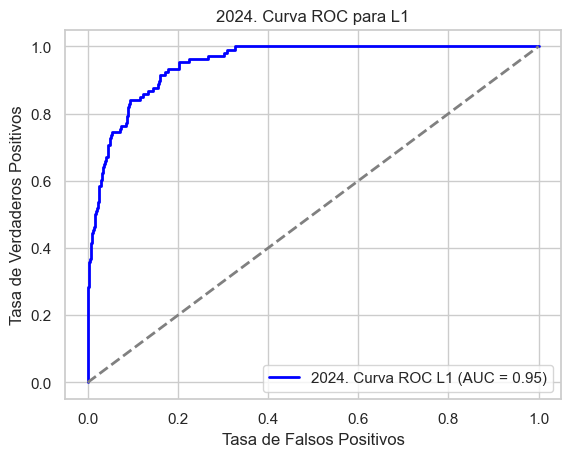


2024. Matriz de confusión L2:
[[1828    6]
 [  72   34]]
2024. Accuracy L2: 0.9597938144329897
2024. AUC L2: 0.9424857513219893


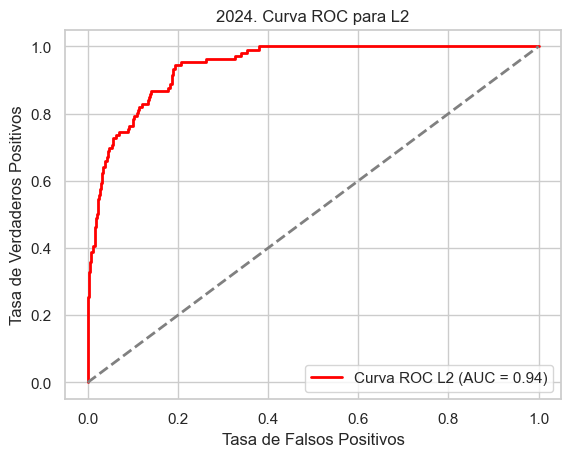

In [44]:
# Configuración del modelo de regresión logística con penalización L1 (LASSO)
model_l1_24 = LogisticRegression(penalty='l1', C=1, solver='liblinear')  # L1 penalidad, solver liblinear para L1
model_l1_24.fit(X_train_2024_trans, y_train_2024)
pred_l1_24 = model_l1_24.predict(X_test_2024_trans)
pred_prob_l1_24 = model_l1_24.predict_proba(X_test_2024_trans)[:, 1]

# Evaluación para L1
cm_l1_24 = confusion_matrix(y_test_2024, pred_l1_24)
accuracy_l1_24 = accuracy_score(y_test_2024, pred_l1_24)
fpr_l1_24, tpr_l1_24, _ = roc_curve(y_test_2024, pred_prob_l1_24)
roc_auc_l1_24 = auc(fpr_l1_24, tpr_l1_24)

print("2024. Matriz de confusión L1:")
print(cm_l1_24)
print("2024. Accuracy L1:", accuracy_l1_24)
print("2024. AUC L1:", roc_auc_l1_24)

# Visualización de la curva ROC para L1
plt.figure()
plt.plot(fpr_l1_24, tpr_l1_24, color='blue', lw=2, label='2024. Curva ROC L1 (AUC = %0.2f)' % roc_auc_l1_24)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('2024. Curva ROC para L1')
plt.legend(loc='lower right')
plt.show()

# Configuración del modelo de regresión logística con penalización L2 (Ridge)
model_l2_24 = LogisticRegression(penalty='l2', C=1, solver='liblinear')  # L2 penalidad
model_l2_24.fit(X_train_2024_trans, y_train_2024)
pred_l2_24 = model_l2_24.predict(X_test_2024_trans)
pred_prob_l2_24 = model_l2_24.predict_proba(X_test_2024_trans)[:, 1]

# Evaluación para L2
cm_l2_24 = confusion_matrix(y_test_2024, pred_l2_24)
accuracy_l2_24 = accuracy_score(y_test_2024, pred_l2_24)
fpr_l2_24, tpr_l2_24, _ = roc_curve(y_test_2024, pred_prob_l2_24)
roc_auc_l2_24 = auc(fpr_l2_24, tpr_l2_24)

print("\n2024. Matriz de confusión L2:")
print(cm_l2_24)
print("2024. Accuracy L2:", accuracy_l2_24)
print("2024. AUC L2:", roc_auc_l2_24)

# Visualización de la curva ROC para L2
plt.figure()
plt.plot(fpr_l2_24, tpr_l2_24, color='red', lw=2, label='Curva ROC L2 (AUC = %0.2f)' % roc_auc_l2_24)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('2024. Curva ROC para L2')
plt.legend(loc='lower right')
plt.show()

### PUNTO 5
Realicen un barrido en λ= 10^n con n ∈ {−5, −4, −3 ..., +4, +5} y utilicen 10-fold CV para elegir el λ óptimo en regresión logística con Ridge y con LASSO. ¿Qué λ seleccionó en cada caso? 

Usando la librería de seaborn, generen box plot mostrando la distribución del error de predicción para cada λ. Cada box debe corresponder a un valor de λ y contener como observaciones el error medio de validación (MSE) para cada partición. 

Además, para la regularización LASSO, generen un line plot del promedio de la proporción de variables ignoradas por el modelo en función de (como vieron en el tutorial 10), es decir la proporción de λ variables para las cuales el coeficiente asociado es cero (Hint: a mayor penalidad, esperamos que más coeficientes sean 0, por lo tanto, esta figura debe tener una forma de “S”)

### 2004

In [45]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

In [56]:
# Rango de valores de n
exponentes = np.arange(-5, 6, 1)  # Genera [-5, -4, ..., 4, 5]

# Usar 10.0 en lugar de 10 para evitar el ValueError
alphas_ridge = 10.0 ** exponentes  # 10^n para Ridge
alphas_lasso = 10.0 ** exponentes  # 10^n para Lasso

print("Valores de alphas para Ridge:", alphas_ridge)
print("Valores de alphas para Lasso:", alphas_lasso)

Valores de alphas para Ridge: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
Valores de alphas para Lasso: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]


In [61]:
# Ridge con validación cruzada 2004
ridgecv_2004 = RidgeCV(alphas=alphas_ridge, cv=10)
ridgecv_2004.fit(X_train_2004_trans, y_train_2004)
print("Mejor alpha para Ridge:", ridgecv_2004.alpha_)

# Estimación final de Ridge con el mejor alpha
ridge_2004 = Ridge(alpha=ridgecv_2004.alpha_)
ridge_2004.fit(X_train_2004_trans, y_train_2004)
ridge_pred_2004 = ridge_2004.predict(X_test_2004_trans)
ecm_ridge_2004 = mean_squared_error(y_test_2004, ridge_pred_2004)

print("Error cuadrático medio para Ridge: ", ecm_ridge_2004)
print("Coeficientes del mejor modelo Ridge:")
print(pd.Series(ridge_2004.coef_, index=X_train_2004_trans.columns))

Mejor alpha para Ridge: 100.0
Error cuadrático medio para Ridge:  0.05834663634769526
Coeficientes del mejor modelo Ridge:
ix_tot                    -0.020009
ipcf                      -0.021144
ch06                      -0.005371
cat_inac                  -0.099285
componente                 0.003074
h15                        0.009424
v5                         0.002601
v6                        -0.004380
v7                         0.000062
v8                        -0.002187
v11                        0.000845
v12                       -0.003583
v13                        0.001730
v17                        0.016887
v19_a                     -0.003194
v19_b                      0.001937
ch03_1                    -0.022179
ch03_2                     0.008950
ch03_3                     0.010512
ch03_4                     0.005983
ch03_5                    -0.000157
ch03_6                     0.000021
ch03_7                     0.003066
ch03_8                     0.004094
ch03_9       

In [62]:
# Lasso con validación cruzada
lassocv_04 = LassoCV(alphas=alphas_lasso, cv=10, max_iter=100000, random_state=100)
lassocv_04.fit(X_train_2004_trans, y_train_2004)
print("Mejor alpha para Lasso:", lassocv_04.alpha_)

# Estimación final de Lasso con el mejor alpha
lasso_04 = Lasso(alpha=lassocv_04.alpha_)
lasso_04.fit(X_train_2004_trans, y_train_2004)
lasso_pred = lasso_04.predict(X_test_2004_trans)
ecm_lasso = mean_squared_error(y_test_2004, lasso_pred)

print("Error cuadrático medio para Lasso: ", ecm_lasso)
print("Coeficientes del mejor modelo Lasso:")
coeficientes_lasso_04 = pd.Series(lasso_04.coef_, index=X_train_2004_trans.columns)
print(coeficientes_lasso_04[coeficientes_lasso_04 != 0])
# Guardar coeficientes en un DataFrame
coeficientes_finales_04 = pd.DataFrame([np.array(X_train_2004_trans.columns.tolist()), lasso_04.coef_]).T
coeficientes_finales_04.columns = ['feature', 'coeficiente']
print(f"El modelo Lasso final cuenta con: {coeficientes_finales_04[coeficientes_finales_04['coeficiente'] != 0].shape[0]}", 'features')
print(coeficientes_finales_04)

Mejor alpha para Lasso: 0.001
Error cuadrático medio para Lasso:  0.05825195457253518
Coeficientes del mejor modelo Lasso:
ix_tot                    -1.847838e-02
ipcf                      -2.029817e-02
ch06                      -2.116684e-03
cat_inac                  -1.008084e-01
componente                 1.790073e-03
h15                        4.178811e-03
v5                         6.721809e-04
v6                        -4.494170e-03
v8                        -1.290752e-03
v11                        6.882672e-05
v12                       -3.030347e-03
v17                        1.467497e-02
v19_a                     -2.727482e-03
ch03_1                    -3.306221e-02
ch03_4                     2.749207e-03
ch03_5                    -2.815928e-03
ch03_6                    -1.997342e-03
ch03_8                     1.135761e-03
ch03_9                    -3.895513e-03
ch03_10                    4.135179e-03
ch04_1                    -6.300972e-03
ch04_2                     1.141125e-

#### 2024

In [63]:
# Ridge con validación cruzada 2004
ridgecv_2024 = RidgeCV(alphas=alphas_ridge, cv=10)
ridgecv_2024.fit(X_train_2024_trans, y_train_2024)
print("Mejor alpha para Ridge:", ridgecv_2024.alpha_)

# Estimación final de Ridge con el mejor alpha
ridge_2024 = Ridge(alpha=ridgecv_2024.alpha_)
ridge_2024.fit(X_train_2024_trans, y_train_2024)
ridge_pred_2024 = ridge_2024.predict(X_test_2024_trans)
ecm_ridge_2024  = mean_squared_error(y_test_2024, ridge_pred_2024)

print("Error cuadrático medio para Ridge: ", ecm_ridge_2024 )
print("Coeficientes del mejor modelo Ridge:")
print(pd.Series(ridge_2024.coef_, index=X_train_2024_trans.columns))

Mejor alpha para Ridge: 100.0
Error cuadrático medio para Ridge:  0.04460186076544927
Coeficientes del mejor modelo Ridge:
ix_tot                    -0.007537
ipcf                      -0.002909
ch06                      -0.019755
cat_inac                  -0.054524
componente                -0.001434
h15                        0.004870
v5                        -0.011187
v6                        -0.001289
v7                         0.001305
v8                        -0.000869
v11                       -0.000831
v12                        0.001744
v13                       -0.001390
v17                       -0.003676
v19_a                      0.000000
v19_b                     -0.000016
ch03_1                    -0.007580
ch03_2                    -0.004296
ch03_3                     0.007497
ch03_4                    -0.000921
ch03_5                     0.001591
ch03_6                     0.002854
ch03_7                     0.004686
ch03_8                     0.001671
ch03_9       

In [64]:
# Lasso con validación cruzada
lassocv_24 = LassoCV(alphas=alphas_lasso, cv=10, max_iter=100000, random_state=100)
lassocv_24.fit(X_train_2024_trans, y_train_2024)
print("Mejor alpha para Lasso:", lassocv_24.alpha_)

# Estimación final de Lasso con el mejor alpha
lasso_24 = Lasso(alpha=lassocv_24.alpha_)
lasso_24.fit(X_train_2024_trans, y_train_2024)
lasso_pred_24 = lasso_24.predict(X_test_2024_trans)
ecm_lasso_24 = mean_squared_error(y_test_2024, lasso_pred_24)

print("Error cuadrático medio para Lasso: ", ecm_lasso_24)
print("Coeficientes del mejor modelo Lasso:")
coeficientes_lasso_24 = pd.Series(lasso_24.coef_, index=X_train_2024_trans.columns)
print(coeficientes_lasso_24[coeficientes_lasso_24 != 0])
# Guardar coeficientes en un DataFrame
coeficientes_finales_24 = pd.DataFrame([np.array(X_train_2024_trans.columns.tolist()), lasso_24.coef_]).T
coeficientes_finales_24.columns = ['feature', 'coeficiente']
print(f"El modelo Lasso final cuenta con: {coeficientes_finales_24[coeficientes_finales_24['coeficiente'] != 0].shape[0]}", 'features')
print(coeficientes_finales_24)


Mejor alpha para Lasso: 0.001
Error cuadrático medio para Lasso:  0.04458563846299403
Coeficientes del mejor modelo Lasso:
ix_tot                    -7.406707e-03
ipcf                      -1.661157e-03
ch06                      -1.755622e-02
cat_inac                  -5.411319e-02
h15                        2.593211e-03
v5                        -1.280683e-02
v6                        -1.925650e-03
v13                       -1.298767e-05
ch03_1                    -6.684511e-03
ch03_2                    -3.279272e-03
ch03_3                     4.698560e-03
ch03_4                    -2.031432e-04
ch03_6                     1.315328e-03
ch03_7                     3.461482e-03
ch03_8                     3.094687e-04
ch03_9                     4.478666e-03
ch04_1                    -4.689396e-03
ch04_2                     7.264059e-18
ch07_2                    -1.080588e-03
ch07_3                     8.317610e-03
ch07_4                    -3.769549e-03
ch07_5                     4.615576e-

### PUNTO 6 - TEORICO
En el caso del valor óptimo de λ para LASSO encontrado en el inciso  anterior, ¿qué variables fueron descartadas? ¿Son las que hubieran esperado? ¿Tiene relación con lo que respondieron en el inciso 1 de la Parte I?

### PUNTO 7 - TEORICO
Elijan alguno de los modelos de regresión logística donde hayan probado distintos parámetros de regularización y comenten: Compare los resultados de 2004 versus 2024, ¿qué método de regularización funcionó mejor: Ridge o LASSO? ¿LASSO hizo una selección distinta de predictores en 2004 versus 2024? Comenten mencionando el error cuadrático medio (MSE)

In [70]:
print("Error cuadrático medio con Ridge 2024: ",mean_squared_error(y_test_2004, ridge_pred_2004))
print("Error cuadrático medio con Lasso 2004: ",mean_squared_error(y_test_2004, lasso_pred))

print("Error cuadrático medio con Ridge 2024: ", mean_squared_error(y_test_2024, ridge_pred_2024))
print("Error cuadrático medio con Lasso 2024: ", mean_squared_error(y_test_2024, lasso_pred_24))

Error cuadrático medio con Ridge 2024:  0.05834663634769526
Error cuadrático medio con Lasso 2004:  0.05825195457253518
Error cuadrático medio con Ridge 2024:  0.04460186076544927
Error cuadrático medio con Lasso 2024:  0.04458563846299403
